<a href="https://colab.research.google.com/github/KumudaBG/DeepLearning-Assignment3/blob/main/c1_tensorflow_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
n  = 270
d = 3
x = tf.random.uniform((n, d), -1, 1)
x2 = tf.cast(x**2, tf.float32)
weights_true = tf.cast(tf.constant([[5,1,2],[2,2,1]]), tf.float32)
bias_true = tf.cast(tf.constant([1,2]), tf.float32)
y_true = tf.matmul(x2, weights_true, transpose_b=True) + tf.matmul(x,weights_true,transpose_b=True) + bias_true

print(f'y: {y_true.shape}')

y: (270, 2)


#Visualization

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [ ]:
import plotly.graph_objects as pltgo
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [ ]:
X = TSNE(n_components=2).fit_transform(x)
Y = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X,Y)

#Loss function Mean Square Error

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return tf.reduce_mean((y_pred - y_true) ** 2)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

#ReLU activation function

In [ ]:
class Relu:
    def __call__(self, input_):
      import math
      self.input_ = input_
      self.output = tf.clip_by_value(self.input_, 0, math.inf)
      return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = tf.cast((self.input_ > 0), tf.float32) * output_gradient
      return self.input_gradient

#Nueral network using Tensorflow

In [ ]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = tf.Variable(tf.random.uniform(shape=(input_dim, num_hidden)))
    self.bias = tf.Variable(tf.zeros(shape=(num_hidden,)))
  
  def __call__(self, x):
    self.x = x
    return tf.matmul(x, self.weights) + self.bias

  def backward(self, gradient):
    self.weights_gradient = tf.matmul(self.x,gradient,transpose_a=True)
    self.bias_gradient = tf.reduce_sum(gradient, 0)
    self.x_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [ ]:
from typing import Callable
class Model:
  def __init__(self, input_dim, num_hidden=8):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden, 8)
    self.relu2 = Relu()
    self.linear3 = Linear(8,2)
  
  # Forward pass
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

In [ ]:
from typing import Callable
def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 50 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

loss = MSE()
model = Model(d, 10)
fit(x, y_true, model=model, loss=loss, lr=0.0025, num_epochs=1000)

Epoch 0, loss 39.487361907958984
Epoch 50, loss 2.473914623260498
Epoch 100, loss 1.3155676126480103
Epoch 150, loss 0.9435997009277344
Epoch 200, loss 0.7071791291236877
Epoch 250, loss 0.5281610488891602
Epoch 300, loss 0.3919013440608978
Epoch 350, loss 0.2945842146873474
Epoch 400, loss 0.22823432087898254
Epoch 450, loss 0.184146448969841
Epoch 500, loss 0.15575449168682098
Epoch 550, loss 0.13757868111133575
Epoch 600, loss 0.12509267032146454
Epoch 650, loss 0.11612976342439651
Epoch 700, loss 0.1092686727643013
Epoch 750, loss 0.10388284921646118
Epoch 800, loss 0.09944438189268112
Epoch 850, loss 0.095773845911026
Epoch 900, loss 0.09260820597410202
Epoch 950, loss 0.08978168666362762


In [ ]:

# Test just one forward and backward step
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

tf.Tensor(0.08721631, shape=(), dtype=float32)
tf.Tensor(0.085344456, shape=(), dtype=float32)


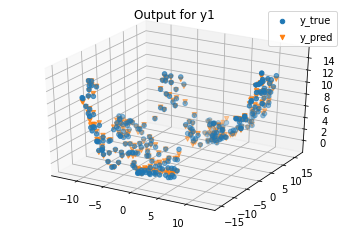

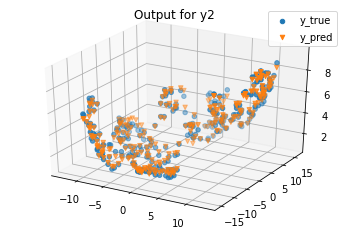

In [ ]:
plot_3d('Output for y1', x, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', x, y_true[:,1], y_pred[:,1])

In [ ]:
X_plot = TSNE(n_components=2).fit_transform(x)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)